In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np
import cv2
from corners import *

In [12]:
# RGB to gray
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [13]:
def loadImages():
    images = []
    for i in range(1,11):
        location = "images\\%d.jpg"%i
        img = rgb2gray(mpl.image.imread(location))
        images.append(img)
    return images

In [14]:
def getFeaturePoints(img):
    result = cornerDetect(img, winSize=21, k=0.04, thd=1e14, type=1)
    # Non maximum suppression
    tempScale = np.pad(result, 2, mode='constant')
    width, height = tempScale.shape
    for x in range(2, width-2):
        for y in range(2, height-2):
            if tempScale[x][y] != np.max(tempScale[x-2:x+3, y-2:y+3]):
                tempScale[x][y] = 0
    result = tempScale[2:width-2, 2:height-2]
    y, x = np.nonzero(result)
    
    # plot 
    print('Number of corner : %d'%y.shape)
    return x,y

In [15]:
def getFeatureDescriptors(X, Y, winSize, img):
    neighbors = []
    for x, y in zip(X,Y):
        patch_center = np.array([x, y])
        image = np.array(img)
        patch_size = winSize
        patch_x = int(patch_center[1] - patch_size / 2.)
        patch_y = int(patch_center[0] - patch_size / 2.)
        if patch_x < 0 or patch_y < 0:
            #print('!')
            continue
        patch_image = image[patch_x:patch_x+patch_size, patch_y:patch_y+patch_size]
        #patch_image = np.float32(patch_image)/255.0
        neighbors.append(patch_image)
    return neighbors

In [16]:
images = loadImages()

In [17]:
img1X,img1Y = getFeaturePoints(images[0])

Number of corner : 483


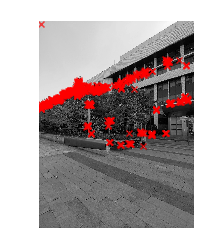

In [18]:
plt.imshow(images[0], cmap='gray')
plt.scatter(img1X, img1Y, marker='x', alpha = 0.7,color='r')
plt.axis('off')
plt.show()

In [19]:
test = getFeatureDescriptors(img1X, img1Y, 100, images[0])

In [9]:
hog = cv2.HOGDescriptor()

In [10]:
im = test[0].astype(np.uint8)

In [ ]:
descriptor = hog.compute(im)

In [ ]:
descriptor